In [4]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
cproj = cartopy.crs.PlateCarree()
xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7]

## **Physical geography**

In [127]:
elev = xr.open_dataset("data/gebco_2023_n10.0_s6.0_w-85.0_e-75.0.nc").elevation
# sf = gpd.read_file("sf_hybas05").clip((xn, xx, yn, yx))

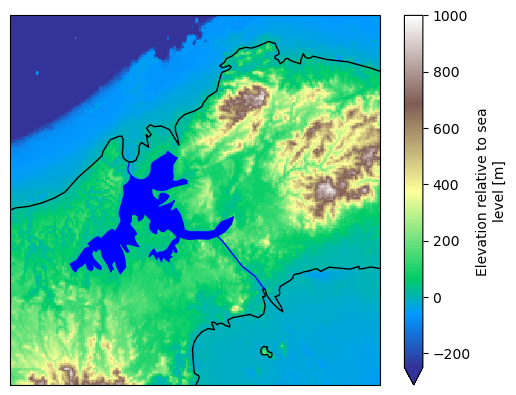

In [128]:
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(cmap = "terrain", vmax = 1000, vmin = -250, subplot_kws = {"projection" : cproj})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "blue")
ax.add_feature(cartopy.feature.RIVERS, color = "blue")
# sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)  # shapefile doesn't give much more detail than the box

## **Lake level data**
https://evtms-rpts.pancanal.com/eng/h2o/index.html (https://pancanal.com/en/)

- the three driest years observed were 1997, 2015 and 2023 (in order of accumulated precip deficit by September)  
- in all three of these years, the lake levels were roughly the same at the start of the year (about 87.5ft) -
the 2023 level has dropped much more quickly than in either 1997 or 2015.  
&nbsp;
- Jun-Sep 2023 is the longest that levels have remained this low.
&nbsp;
- previously, the lowest levels have occurred in April-June of the years following the lowest precipitation, then recovered quickly.  
This suggests that next year, levels might be even lower.


In [102]:
df = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
df = df.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"})

In [103]:
df.loc[df.level == 0, "level"] = np.nan # remove zeros

In [104]:
df[np.abs(df - df.rolling(15).mean()) > 1] = np.nan # remove any readings that are more than 1ft from the smoothed line

In [105]:
df.loc[["1997-01-01", "2015-01-01", "2023-01-01"]] % 87

,level
DATE_LOG,
1997-01-01,0.59
2015-01-01,0.36
2023-01-01,0.65


In [106]:
df_clim = df.loc[slice("1990", "2020")].groupby(df.loc[slice("1990", "2020")].index.day_of_year).mean()

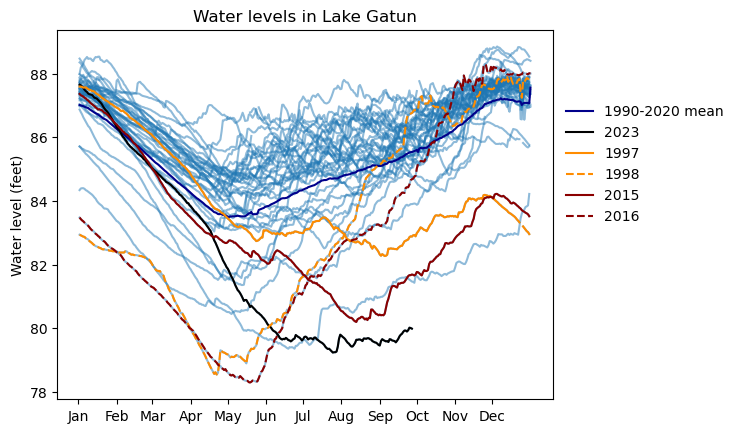

In [128]:
df_clim.plot(color = "darkblue", legend = False)
ax = plt.gca()
   
ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False)

ts_y = df.loc[str(1997)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkorange", legend = False)

ts_y = df.loc[str(1998)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkorange", legend = False, ls = "--")

ts_y = df.loc[str(2015)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkred", legend = False)

ts_y = df.loc[str(2016)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "darkred", legend = False, ls = "--")

for y in range(1981, 2024):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.5, legend = False, label = "_", zorder = -99)

sc_xlabels(dates = chirps_ts.sel(time = "2000").time)
plt.gcf().legend(["1990-2020 mean", "2023", "1997","1998","2015","2016"], bbox_to_anchor = (0.9,0.6), loc = "center left", edgecolor = "w")
ax.set_xlabel("")
ax.set_ylabel("Water level (feet)")
ax.set_title("Water levels in Lake Gatun")

plt.savefig("fig/water-levels.png")

# **Gridded data**

## **CHIRPS**

In [65]:
chirps = xr.open_dataset("data/chirps05_panama.nc").pr.sel(longitude = slice(xn,xx), latitude = slice(yn, yx))
chirps_ts = chirps.mean(["latitude", "longitude"])

chirps_ts.to_dataframe().to_csv("data/chirps_panama_ts.csv")
chirps_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/chirps_monthly.csv")

### **Anomalies over this region**

In [90]:
chirps_clim_9020 = chirps_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()
chirps_clim_1020 = chirps_ts.sel(time = slice("2010", "2020")).groupby("time.dayofyear").mean()

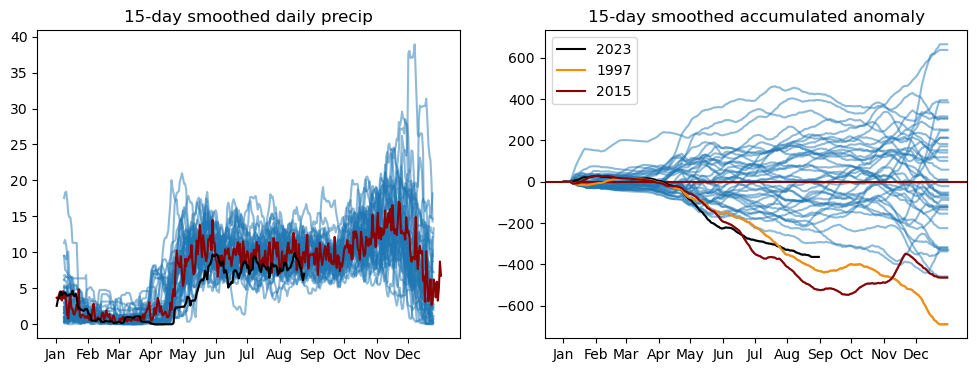

In [166]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(chirps_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(clim_1020.dayofyear, clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(chirps_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k")
ax.set_title("15-day smoothed daily precip")
sc_xlabels(dates = chirps_ts.sel(time = "2000").time, ax = ax)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - chirps_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(chirps_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkred")
# ax.plot(chirps_clim_9020.dayofyear, chirps_clim_9020, color = "darkred")
# ax.plot(chirps_clim_1020.dayofyear, chirps_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(chirps_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(chirps_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(chirps_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend()
ax.set_title("15-day smoothed accumulated anomaly")
sc_xlabels(dates = chirps_ts.sel(time = "2000").time, ax = ax)

- 2023 has been a dry year - however, not the driest on record - both 1997 and 2015 had a larger precipitation deficit by the end of August.  
- 2023 differs in that May and June were very dry; the last few months have been below average, but not catastrophically dry

## **MSWEP**

In [87]:
mswep = xr.open_dataset("data/mswep_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx))
mswep = mswep.where(regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(mswep.lon, mswep.lat).squeeze(drop = True))
mswep_ts = mswep.mean(["lat", "lon"])
mswep_ts.to_dataframe().to_csv("data/mswep_panama_ts.csv")

mswep_ts.resample(time = "MS").mean().to_dataframe().to_csv("data/mswep_monthly.csv")

### **Anomalies over this region**

In [88]:
mswep_clim_9020 = mswep_ts.sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()
mswep_clim_1020 = mswep_ts.sel(time = slice("2010", "2020")).groupby("time.dayofyear").mean()

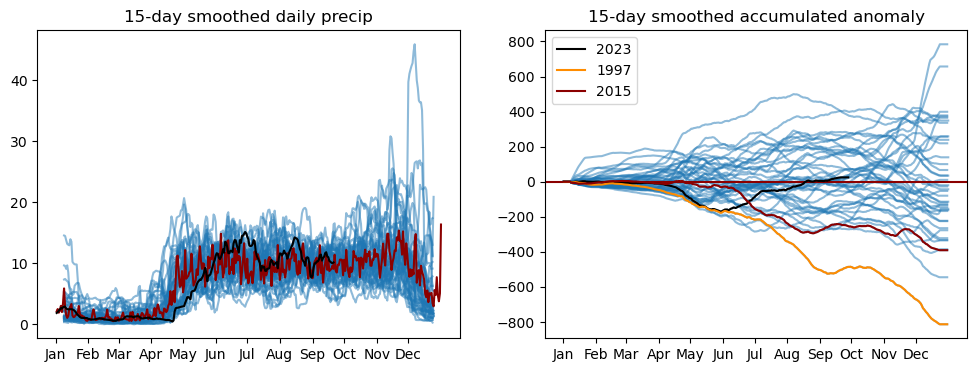

In [186]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def ts_fun(ts): return ts.rolling(time = 15, center = True).mean()
ax = axs[0]

for y in range(1981, 2024):
    ts_y = ts_fun(mswep_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.plot(mswep_clim_9020.dayofyear, mswep_clim_9020, color = "darkred")
# ax.plot(mswep_clim_1020.dayofyear, mswep_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(mswep_ts).sel(time = str(2023))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k")
ax.set_title("15-day smoothed daily precip")
sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# cumulative anomaly
def ts_fun(ts): return (ts.rolling(time = 15, center = True).mean() - mswep_clim_9020.values[:len(ts)]).cumsum()
ax = axs[1]

for y in range(1981, 2024):
    ts_y = ts_fun(mswep_ts.sel(time = str(y)))
    ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5)
    
ax.axhline(0, color = "darkred")
# ax.plot(mswep_clim_9020.dayofyear, mswep_clim_9020, color = "darkred")
# ax.plot(mswep_clim_1020.dayofyear, mswep_clim_1020, color = "red")  # basically same as above

ts_y = ts_fun(mswep_ts.sel(time = str(2023)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = "2023")

ts_y = ts_fun(mswep_ts.sel(time = str(1997)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkorange", label = "1997")

ts_y = ts_fun(mswep_ts.sel(time = str(2015)))
ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = "2015")

ax.legend()
ax.set_title("15-day smoothed accumulated anomaly")
sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)

## **Compare CHIRPS & MSWEP**

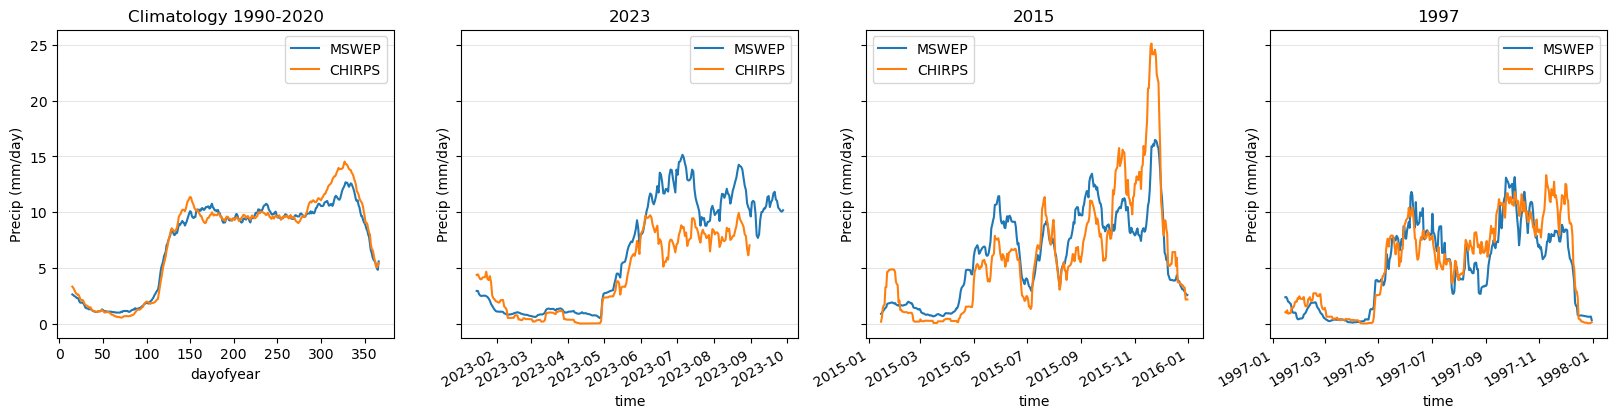

In [101]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,4), dpi = 100, sharey = True)

for i in range(4):
    mswep_dat = ([mswep_clim_9020] + [mswep_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]
    chirps_dat = ([chirps_clim_9020] + [chirps_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]

    mswep_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "MSWEP")
    chirps_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "CHIRPS")
    axs[i].legend()
    axs[i].set_ylabel("Precip (mm/day)")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    
axs[0].set_title("Climatology 1990-2020")
axs[1].set_title("2023")
axs[2].set_title("2015")
axs[3].set_title("1997")

plt.savefig("fig/mswep-chirps-precipitation.png")

In [133]:
# smoothed climatology
chirps_clim_9020 = chirps_ts.rolling(time = 15).mean().sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()
mswep_clim_9020 = mswep_ts.rolling(time = 15).mean().sel(time = slice("1990", "2020")).groupby("time.dayofyear").mean()

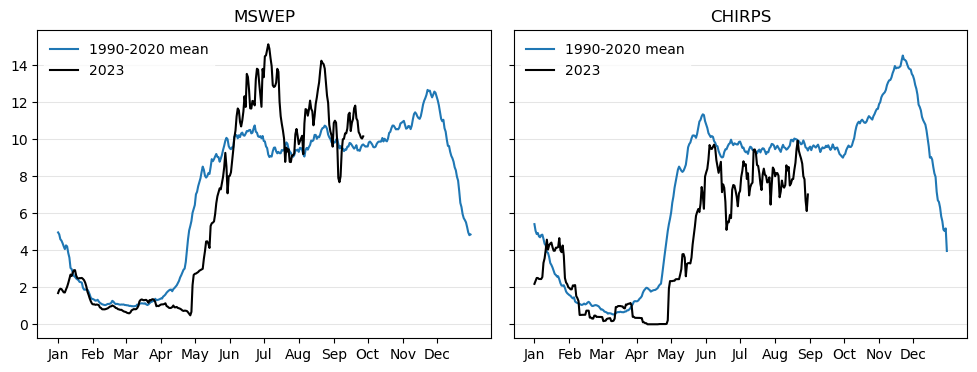

In [148]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True)
plt.subplots_adjust(wspace = 0.05)

for i in range(2):
    
    ax = axs[i]
    ts_clim = [mswep_clim_9020, chirps_clim_9020][i]
    ts_2023 = [mswep_ts, chirps_ts][i].rolling(time = 15).mean().loc["2023"].rename(time = "dayofyear")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    ax.plot(ts_clim, label = "1990-2020 mean")
    ax.plot(ts_2023, color = "k", label = "2023")
    
    ax.legend(edgecolor = "w")
    ax.set_title(["MSWEP", "CHIRPS"][i])
    
    sc_xlabels(dates = mswep_ts.sel(time = "2000").time, ax = ax)
    
axs[0].set_label("Precipitation (mm/day)")
plt.savefig("fig/precip-vs-climatology.png")

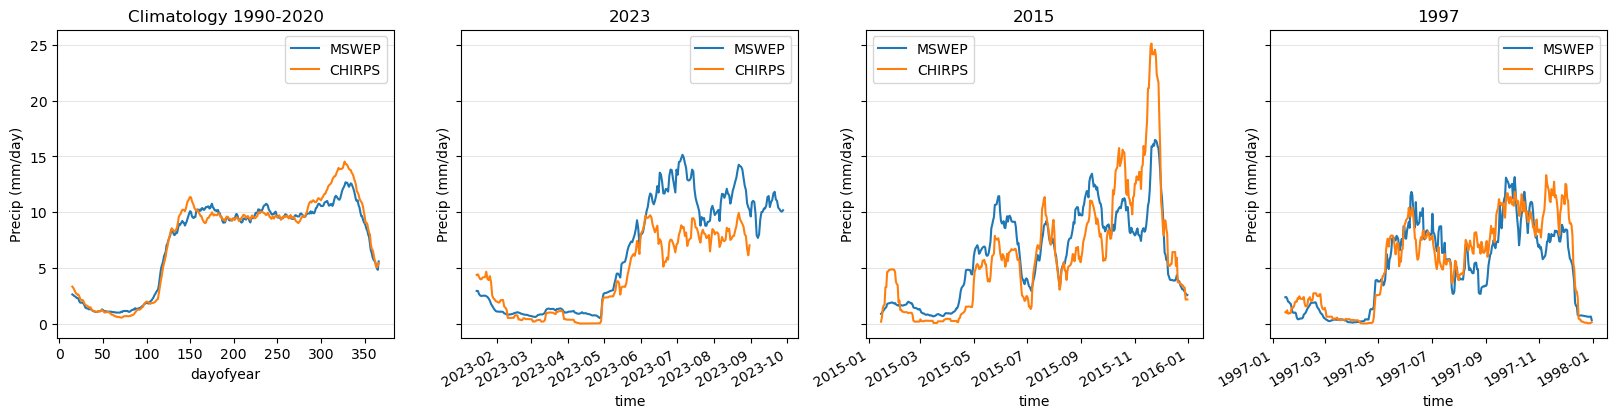

In [101]:
    mswep_dat = ([mswep_clim_9020] + [mswep_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]
    chirps_dat = ([chirps_clim_9020] + [chirps_ts.loc[str(y)].rename(time = "dayofyear") for y in [2023, 2015, 1997]])[i]

    mswep_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "MSWEP")
    chirps_dat.rolling(dayofyear = 15).mean().plot(ax = axs[i], label = "CHIRPS")
    axs[i].legend()
    axs[i].set_ylabel("Precip (mm/day)")
    
    axs[i].grid(color = "k", alpha = 0.1, axis = "y")
    
axs[0].set_title("Climatology 1990-2020")
axs[1].set_title("2023")
axs[2].set_title("2015")
axs[3].set_title("1997")

plt.savefig("fig/mswep-chirps-vs-climatology.png")

## **SPI**
Fitting done in R because Python parameter estimates are unstable

In [74]:
mswep_spi = pd.read_csv("data/mswep_spi-monthly.csv", index_col = "time", parse_dates = ["time"])
chirps_spi = pd.read_csv("data/chirps_spi-monthly.csv", index_col = "time", parse_dates = ["time"])

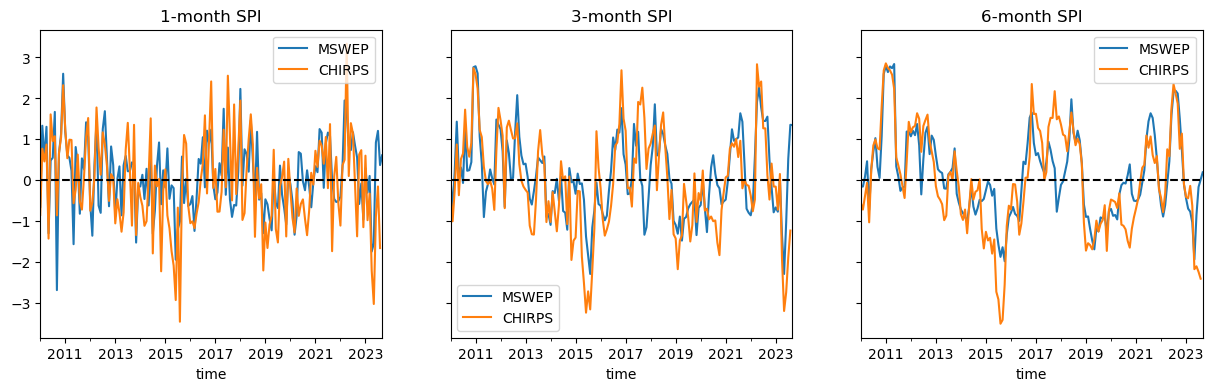

In [84]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 

for i in range(3):
    nm = [1,3,6][i]
    ax = axs[i]
    mswep_spi.loc[slice("2010",None)]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[slice("2010",None)]["spi_"+str(nm)].plot(ax = ax)
    ax.axhline(0, color = "k", ls = "--")

    ax.legend(["MSWEP", "CHIRPS"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi-panama.png")

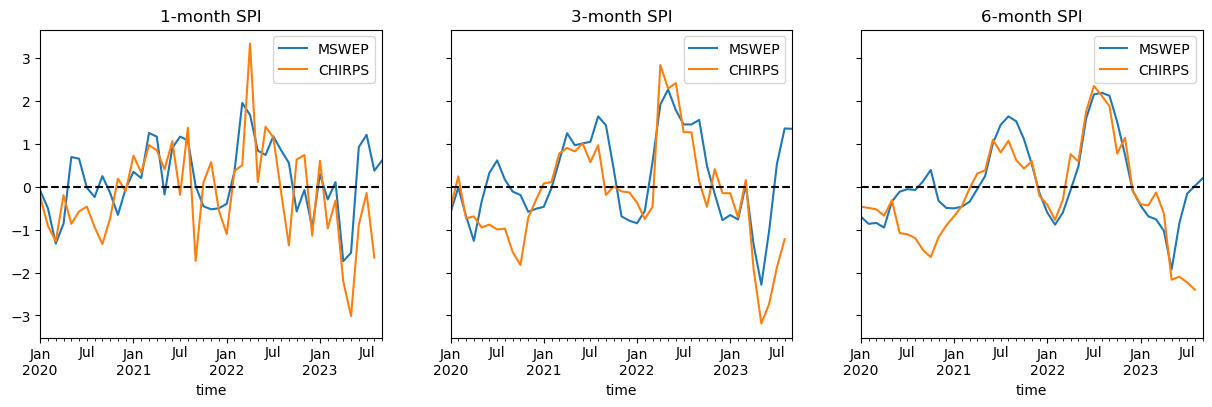

In [129]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,4), dpi = 100, sharex = True, sharey = True) 

for i in range(3):
    nm = [1,3,6][i]
    ax = axs[i]
    mswep_spi.loc[slice("2020",None)]["spi_"+str(nm)].plot(ax = ax)
    chirps_spi.loc[slice("2020",None)]["spi_"+str(nm)].plot(ax = ax)
    ax.axhline(0, color = "k", ls = "--")

    ax.legend(["MSWEP", "CHIRPS"])
    ax.set_title(str(nm)+"-month SPI")
    
plt.savefig("fig/spi-panama_2020s.png")

## **Correlation with lake levels**

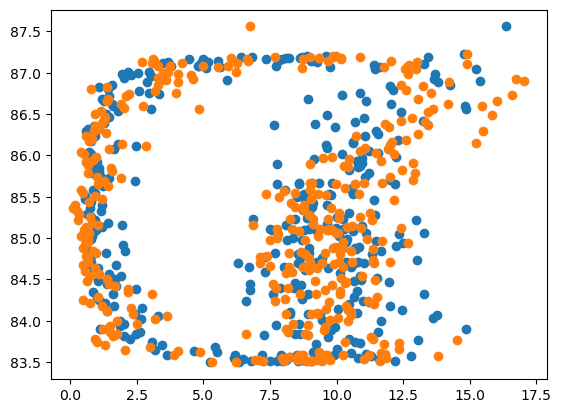

In [216]:
# not sure that this tells us much, but I like the shape
plt.scatter(mswep_clim_9020, df_clim)
plt.scatter(chirps_clim_9020, df_clim)

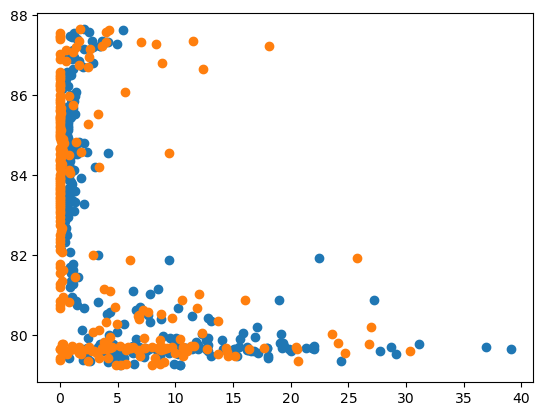

In [237]:
plt.scatter(mswep_ts.sel(time = slice("2023-01-01", "2023-09-27")), df.loc["2023"])
plt.scatter(chirps_ts.sel(time = slice("2023-01-01", "2023-09-27")), df.loc[slice("2023-01-01", "2023-08-31")])